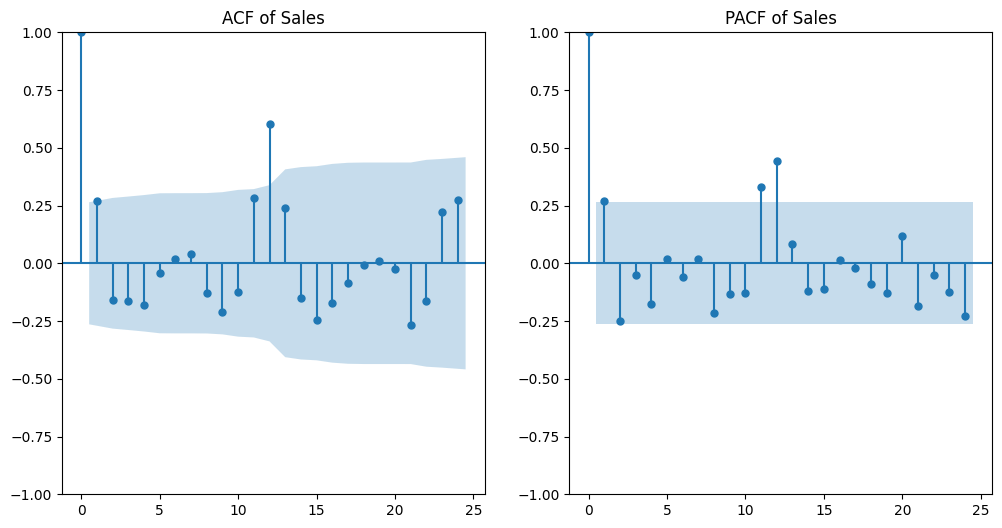

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1812.931, Time=0.21 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1834.686, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1821.097, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1811.291, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1813.158, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1811.615, Time=0.08 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1810.502, Time=0.08 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1812.159, Time=0.11 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1824.504, Time=0.07 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1812.110, Time=0.10 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1814.012, Time=0.09 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=1816.585, Time=0.07 sec
 ARIMA(1,1,2)(0,1,2)[12]             : AIC=1813.197, Time=0.17 sec
 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=1812.070, Time=0.11 sec

Best model:  ARIMA

c:\Users\binay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 452ms/step - loss: 0.4094 - val_loss: 0.0825
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3559 - val_loss: 0.0704
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1440 - val_loss: 0.0619
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0660 - val_loss: 0.0551
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1493 - val_loss: 0.0505
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1712 - val_loss: 0.0492
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1459 - val_loss: 0.0495
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1918 - val_loss: 0.0491
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1208 - val_loss: 0.0475
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2012 - val_loss: 0.0471
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1048 - val_loss: 0.0477
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1992 - val_loss: 0.0481


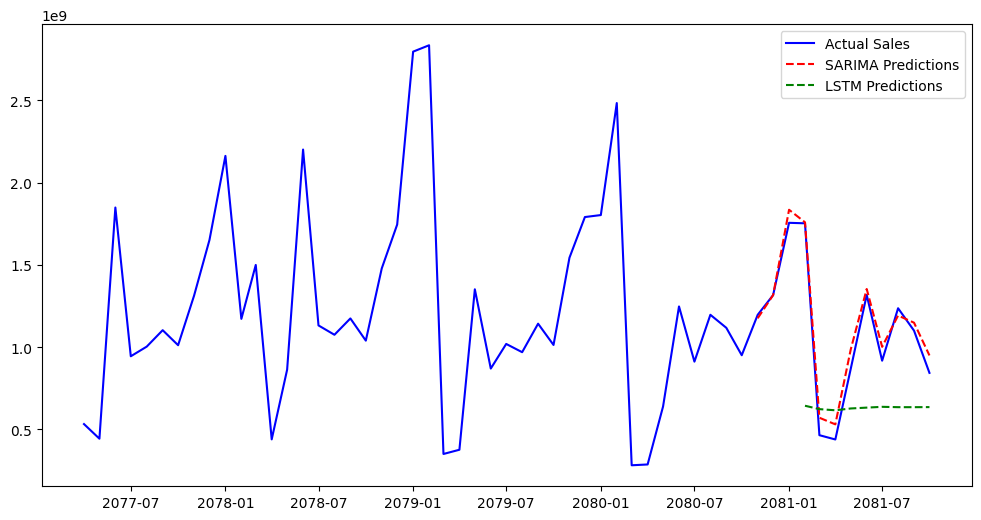

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
# data = pd.read_csv('csv_data/merge.csv', parse_dates=True, index_col='date')
data = pd.read_csv(r'company_06\merge_06.csv', parse_dates=True, index_col='date')


data = data.sort_index()


plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(data['sales'], lags=24, ax=plt.gca())
plt.title("ACF of Sales")
plt.subplot(122)
plot_pacf(data['sales'], lags=24, ax=plt.gca())
plt.title("PACF of Sales")
plt.show()


selected_lags = [1, 11, 12]


sarima_model = auto_arima(data['sales'], seasonal=True, m=12, 
                          d=1, D=1, max_p=5, max_q=5, max_order=10, trace=True, 
                          error_action='ignore', suppress_warnings=True)
sarima_model.summary()

forecast_sarima = sarima_model.predict(n_periods=12)  

mae_sarima = mean_absolute_error(data['sales'][-12:], forecast_sarima)
r2_sarima = r2_score(data['sales'][-12:], forecast_sarima)
print(f'SARIMA -> MAE: {mae_sarima}, R^2: {r2_sarima}')

def create_lagged_features(data, lags):
    X, y = [], []
    for i in range(max(lags), len(data)):
        X.append([data[i-lag] for lag in lags])
        y.append(data[i])
    return np.array(X), np.array(y)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['sales']])

X, y = create_lagged_features(scaled_data, selected_lags)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model=Sequential


model_lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(256, return_sequences=True),
    Dropout(0.4),
    BatchNormalization(),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model_lstm.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

predictions_lstm = model_lstm.predict(X_test)

predictions_lstm_exp = scaler.inverse_transform(predictions_lstm)
y_test_exp = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate LSTM performance
mae_lstm = mean_absolute_error(y_test_exp, predictions_lstm_exp)
r2_lstm = r2_score(y_test_exp, predictions_lstm_exp)
print(f'LSTM -> MAE: {mae_lstm}, R^2: {r2_lstm}')


plt.figure(figsize=(12, 6))
plt.plot(data.index, data['sales'], label='Actual Sales', color='blue')
plt.plot(data.index[-12:], forecast_sarima, label='SARIMA Predictions', linestyle='dashed', color='red')
plt.plot(data.index[-len(y_test_exp):], predictions_lstm_exp, label='LSTM Predictions', linestyle='dashed', color='green')
plt.legend()
plt.show()



C:\Users\binay\AppData\Local\Temp\ipykernel_4280\57668079.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start='2081-11-01', periods=5, freq='M')


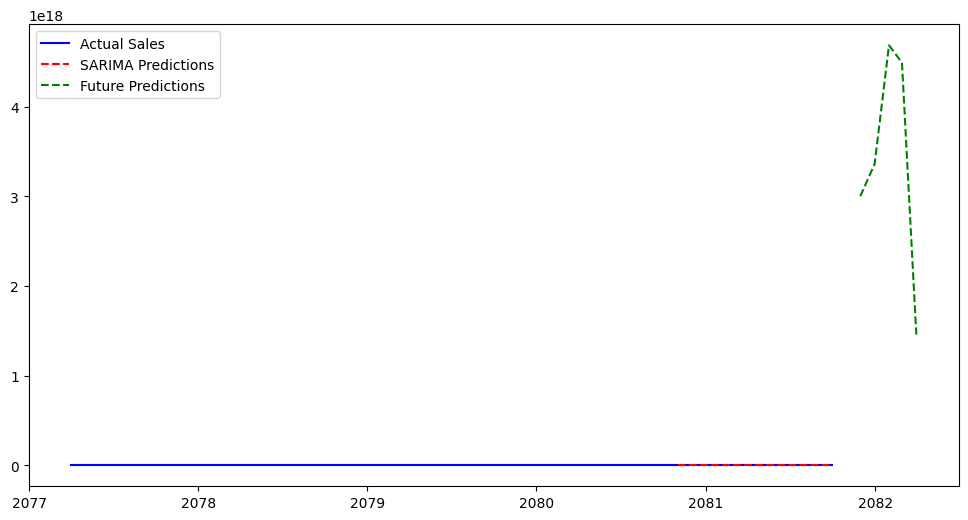

In [4]:
forecast_sarima_next_5 = sarima_model.predict(n_periods=5)

forecast_sarima_next_5_np = np.array(forecast_sarima_next_5).reshape(-1, 1)

# Inverse transform the SARIMA forecasted values (scaling them back to original range)
forecast_sarima_next_5_exp = scaler.inverse_transform(forecast_sarima_next_5_np)

# Create a new time index for the forecast (from Nov 2081 to Mar 2082)
forecast_index = pd.date_range(start='2081-11-01', periods=5, freq='M')

# Plotting the actual data, SARIMA forecast, and LSTM predictions
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['sales'], label='Actual Sales', color='blue')
plt.plot(data.index[-12:], forecast_sarima, label='SARIMA Predictions', linestyle='dashed', color='red')
plt.plot(forecast_index, forecast_sarima_next_5_exp, label='Future Predictions', linestyle='dashed', color='green')

plt.legend()
plt.show()



In [5]:
forecast_sarima_next_5_exp

array([[3.00254252e+18],
       [3.36215512e+18],
       [4.68713185e+18],
       [4.49306041e+18],
       [1.45821582e+18]])

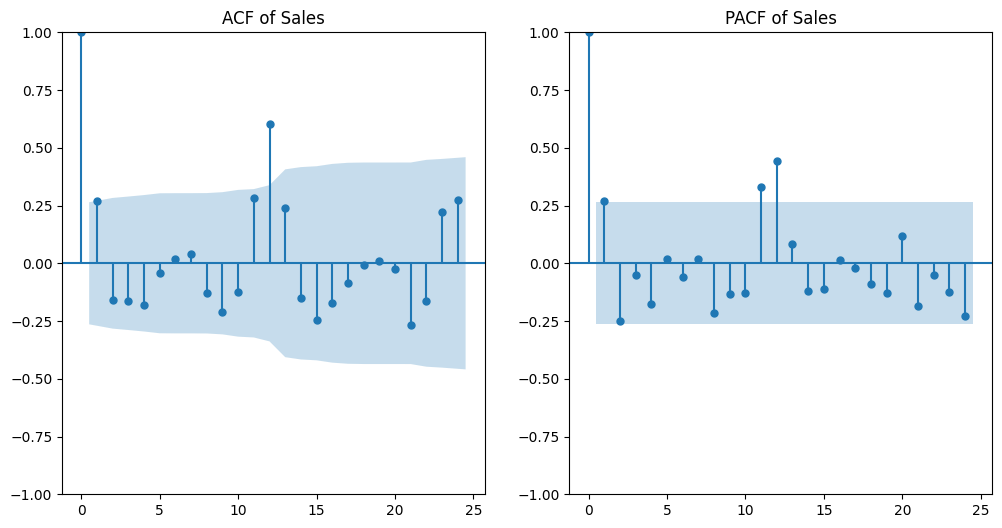

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1350.482, Time=0.17 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1362.651, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1352.847, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1346.482, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1346.376, Time=0.02 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1347.129, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1347.869, Time=0.06 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1347.988, Time=0.02 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=1349.004, Time=0.02 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1352.743, Time=0.01 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1350.497, Time=0.05 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=1345.696, Time=0.02 sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   : AIC=1346.890, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=1346.503, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1

c:\Users\binay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 435ms/step - loss: 0.2892 - val_loss: 0.0881
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1385 - val_loss: 0.0823
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1512 - val_loss: 0.0787
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1537 - val_loss: 0.0755
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2101 - val_loss: 0.0735
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1927 - val_loss: 0.0729
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2658 - val_loss: 0.0717
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1935 - val_loss: 0.0683
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1980 - val_loss: 0.0641
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1346 - val_loss: 0.0608
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1401 - val_loss: 0.0593
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1355 - val_loss: 0.0590


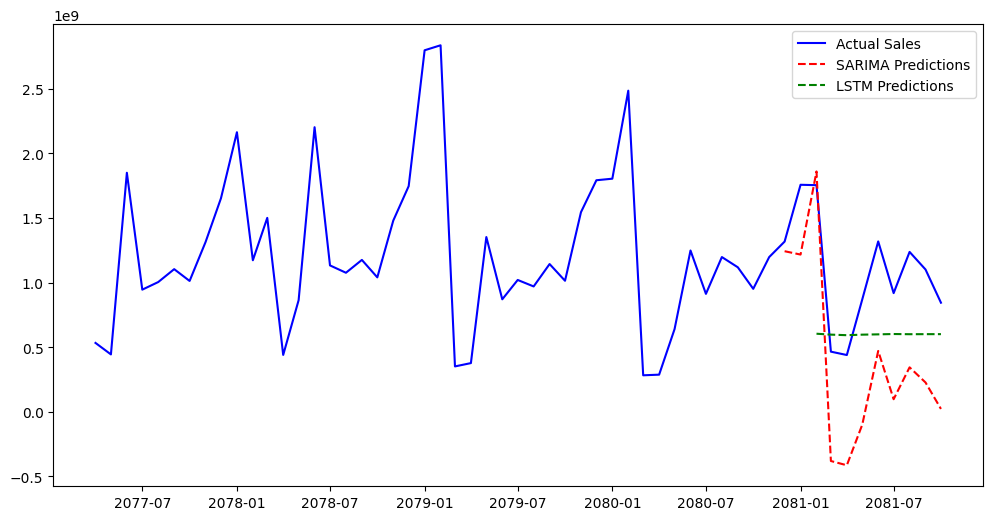

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
data = pd.read_csv(r'company_06\merge_06.csv', parse_dates=True, index_col='date')

# Sort the data by index (date)
data = data.sort_index()

# Plot ACF and PACF of the sales data
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(data['sales'], lags=24, ax=plt.gca())
plt.title("ACF of Sales")
plt.subplot(122)
plot_pacf(data['sales'], lags=24, ax=plt.gca())
plt.title("PACF of Sales")
plt.show()

# Split the data into training and testing sets (80% for training, 20% for testing)
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

# Fit the SARIMA model on the training data
sarima_model = auto_arima(train_data['sales'], seasonal=True, m=12, 
                          d=1, D=1, max_p=5, max_q=5, max_order=10, trace=True, 
                          error_action='ignore', suppress_warnings=True)
sarima_model.summary()

# Forecast the next 12 periods (for the test data)
forecast_sarima = sarima_model.predict(n_periods=len(test_data))

# Evaluate SARIMA performance on test data
mae_sarima = mean_absolute_error(test_data['sales'], forecast_sarima)
r2_sarima = r2_score(test_data['sales'], forecast_sarima)
print(f'SARIMA -> MAE: {mae_sarima}, R^2: {r2_sarima}')

# Function to create lagged features
def create_lagged_features(data, lags):
    X, y = [], []
    for i in range(max(lags), len(data)):
        X.append([data[i-lag] for lag in lags])
        y.append(data[i])
    return np.array(X), np.array(y)

# Create lagged features for LSTM model
selected_lags = [1, 11, 12]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['sales']])

X, y = create_lagged_features(scaled_data, selected_lags)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# LSTM Model Architecture
model_lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(256, return_sequences=True),
    Dropout(0.4),
    BatchNormalization(),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(1)
])

# Compile the LSTM model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the LSTM model
model_lstm.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

# Predict using the trained LSTM model
predictions_lstm = model_lstm.predict(X_test)

# Inverse transform the predictions and test data
predictions_lstm_exp = scaler.inverse_transform(predictions_lstm)
y_test_exp = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate LSTM performance
mae_lstm = mean_absolute_error(y_test_exp, predictions_lstm_exp)
r2_lstm = r2_score(y_test_exp, predictions_lstm_exp)
print(f'LSTM -> MAE: {mae_lstm}, R^2: {r2_lstm}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['sales'], label='Actual Sales', color='blue')
plt.plot(data.index[-len(test_data):], forecast_sarima, label='SARIMA Predictions', linestyle='dashed', color='red')
plt.plot(data.index[-len(y_test_exp):], predictions_lstm_exp, label='LSTM Predictions', linestyle='dashed', color='green')
plt.legend()
plt.show()
